In [54]:
import os
from pathlib import Path
import random
import re

In [2]:
import h5py
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import evaluate
from river import metrics
from river import tree
from sklearn.decomposition import PCA

In [3]:
data_path = Path('datacompletos_sin_escalar.mat')

with h5py.File(data_path, 'r') as data_file:
    data_all = data_file['datacompleto']
    data = pd.DataFrame(data_all).transpose()

In [4]:
# Our dataset doesn't have metadata for what class each experiment belongs to,
# so work it out from the order they're provided in.
def class_mapper(n):
    if n < 2460:
        return 0 # healthy
    elif 2460 <= n < 2460 + 820:
        return 1
    elif 2460 <= n < 2460 + 820*2:
        return 2
    elif 2460 <= n < 2460 + 820*3:
        return 3
    elif 2460 <= n < 2460 + 820*4:
        return 4

data.insert(0, 'class', [class_mapper(i) for i in range(data.shape[0])])

In [5]:
# Shuffle the data so we don't pass it neatly ordered by class
#data = data.sample(frac=1, random_state=0, ignore_index=True)

In [6]:
# PCA fitting
pca = PCA(n_components=8)
pca.fit(data.iloc[:,1:]) # excludes class label column
print(sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

0.38000118649444803
[0.41491926 0.41412494 0.29977859 0.29950598 0.25895515 0.25881002
 0.25513814 0.24110961]


In [7]:
samples_pca = pca.transform(data.iloc[:,1:])

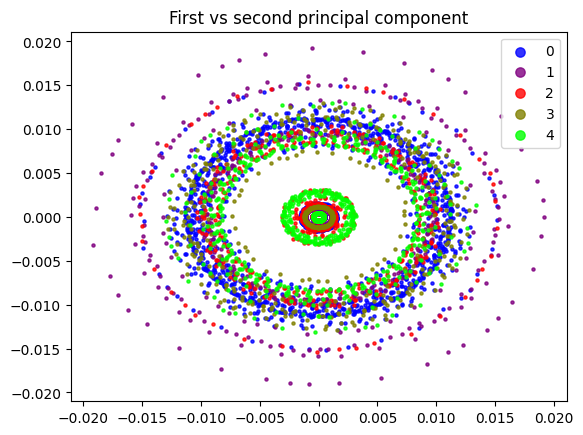

In [35]:
#color_mapping = zip(['green', 'red', 'orange', 'yellow', 'brown'], [0, 1, 2, 3, 4])
color_mapping = zip(['blue', 'purple', 'red', 'olive', 'lime'], [0, 1, 2, 3, 4])
plt.figure()
for color, dataset in color_mapping:
    plt.scatter(
        samples_pca[data['class'] == dataset, 0], samples_pca[data['class'] == dataset, 1], s=5, color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1, markerscale=3)
plt.title("First vs second principal component")
plt.show()

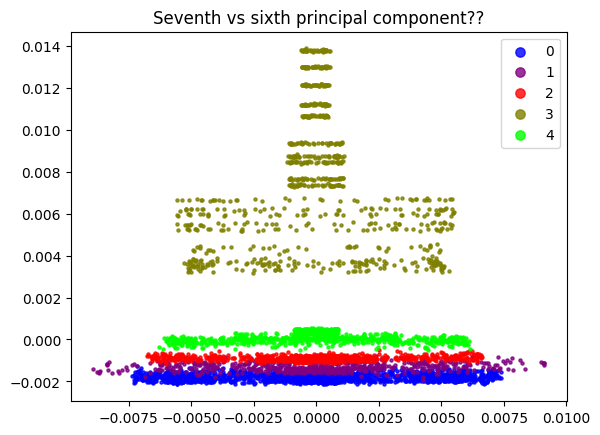

In [36]:
color_mapping = zip(['blue', 'purple', 'red', 'olive', 'lime'], [0, 1, 2, 3, 4])
plt.figure()
for color, dataset in color_mapping:
    plt.scatter(
        samples_pca[data['class'] == dataset, 7], samples_pca[data['class'] == dataset, 6], s=5, color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1, markerscale=3)
#plt.title("Second vs third principal component")
plt.title("Seventh vs sixth principal component??")
plt.show()

In [53]:
samples_pca[0:2]

array([[ 2.59734476e-04,  4.23505156e-04, -1.67263418e-04,
         9.75374001e-05, -2.75635587e-04, -2.96411126e-04,
        -1.69521561e-03, -2.16846964e-04],
       [-3.81644574e-05, -4.49020400e-04,  1.67352166e-04,
         1.00653836e-04,  4.00651985e-04, -2.17270633e-04,
        -1.60934991e-03,  7.66453326e-04]])

In [48]:
for i in range(4):
    print(f"Samples belonging to class {i}: {len(data.loc[data['class'] == i])}")

Samples belonging to class 0: 2460
Samples belonging to class 1: 820
Samples belonging to class 2: 820
Samples belonging to class 3: 820


In [57]:
####################
##### BASELINE #####
####################

# Balance the dataset by ensuring there's about the same amount of experiments for every class i.e. drop a bunch of "healthy" ones

# Choose 820 out of 2460, make a list with those integers
# add numbers 2460-5739 to that array
random.seed(0)
baseline = random.choices(range(2460), k=820)
baseline.extend(range(2460, 5740))

# hmmm results look too good even with this

In [62]:
data.iloc[baseline]

,class,0,1,2,3,4,5,6,7,8,...,57998,57999,58000,58001,58002,58003,58004,58005,58006,58007
2077,0,0.000273,-0.000040,0.000214,-0.000085,0.000083,0.000321,0.000225,0.000075,0.000412,...,-0.000110,0.000014,-0.000066,-0.000109,-0.000142,-0.000093,-0.000163,-0.000142,-0.000196,-0.000132
1864,0,0.000118,0.000342,-0.000043,0.000202,-0.000267,0.000205,0.000263,0.000060,0.000129,...,-0.000068,-0.000100,-0.000061,-0.000078,-0.000060,-0.000008,0.000038,-0.000082,-0.000056,-0.000129
1034,0,0.000226,0.000233,0.000158,0.000230,0.000200,0.000220,0.000167,0.000219,0.000141,...,-0.000072,-0.000054,-0.000034,-0.000063,-0.000071,-0.000065,-0.000104,-0.000071,-0.000011,-0.000057
636,0,0.000212,0.000210,0.000195,0.000221,0.000278,0.000194,0.000265,0.000322,0.000218,...,-0.000050,-0.000074,-0.000083,-0.000008,-0.000083,-0.000085,-0.000043,-0.000029,-0.000058,-0.000053
1257,0,-0.000100,0.000105,-0.000061,0.000091,0.000185,0.000244,0.000184,0.000555,0.000287,...,-0.000090,-0.000102,-0.000044,-0.000022,-0.000082,-0.000062,-0.000027,-0.000168,-0.000036,-0.000147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,4,-0.000027,0.000227,0.000204,0.000353,0.000354,0.000111,0.000486,0.000050,0.000451,...,-0.000094,0.000019,-0.000166,-0.000056,-0.000127,-0.000115,-0.000007,-0.000171,-0.000049,-0.000107
5736,4,0.000504,0.000075,0.000041,0.000130,-0.000018,0.000467,0.000224,0.000639,0.000275,...,-0.000127,-0.000044,-0.000092,-0.000004,-0.000227,-0.000061,-0.000167,-0.000120,-0.000157,-0.000127
5737,4,0.000384,-0.000014,0.000430,0.000190,0.000327,0.000044,-0.000129,-0.000058,0.000045,...,-0.000047,-0.000061,-0.000026,-0.000018,-0.000104,0.000025,-0.000098,-0.000066,-0.000160,-0.000182
5738,4,-0.000146,0.000193,0.000111,-0.000024,0.000506,0.000573,0.000751,0.000365,0.000185,...,-0.000060,-0.000163,-0.000036,-0.000091,-0.000116,-0.000055,-0.000071,0.000016,-0.000105,-0.000044


In [63]:
samples_pca[baseline]

array([[ 1.00213260e-02,  1.43908221e-03,  3.35508722e-03, ...,
         5.26648720e-03, -1.79968824e-03,  6.58258715e-03],
       [ 6.96830648e-03,  1.01575622e-02,  3.78985978e-03, ...,
        -3.90165841e-03, -1.95509594e-03,  3.76032199e-03],
       [-1.44949748e-03,  3.84361235e-04, -6.64645203e-04, ...,
        -9.33541885e-04, -1.80767012e-03,  1.80425596e-04],
       ...,
       [ 2.42553073e-03, -7.92926602e-03, -1.88568266e-03, ...,
         2.36177836e-03, -1.37475677e-04,  2.00871494e-03],
       [-5.83855103e-03,  6.04719460e-03, -3.40798801e-03, ...,
        -4.52498048e-03, -8.67016759e-05, -5.11249305e-03],
       [ 7.90452167e-03, -2.63940916e-03,  6.12796139e-03, ...,
         3.35946574e-04, -2.06115386e-04, -2.87629543e-03]])

In [64]:
zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0)

In [65]:
# Hoeffding tree classifier
model = tree.HoeffdingTreeClassifier(grace_period=10)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    #zip(pd.DataFrame(samples_pca).to_dict(orient='records'), data['class'] == 0),
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    print_every=100,
    show_memory=True)

[100] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[200] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[300] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[400] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[500] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[600] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[700] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[800] ROCAUC: -0.00% – 00:00:00 – 38.15 KB
[900] ROCAUC: 96.25% – 00:00:00 – 73.09 KB
[1,000] ROCAUC: 98.33% – 00:00:00 – 73.11 KB
[1,100] ROCAUC: 98.21% – 00:00:00 – 73.11 KB
[1,200] ROCAUC: 98.68% – 00:00:00 – 73.11 KB
[1,300] ROCAUC: 98.12% – 00:00:00 – 73.11 KB
[1,400] ROCAUC: 98.45% – 00:00:00 – 73.11 KB
[1,500] ROCAUC: 98.53% – 00:00:00 – 73.11 KB
[1,600] ROCAUC: 98.72% – 00:00:00 – 73.11 KB
[1,700] ROCAUC: 98.86% – 00:00:00 – 73.11 KB
[1,800] ROCAUC: 98.98% – 00:00:00 – 73.11 KB
[1,900] ROCAUC: 99.07% – 00:00:00 – 73.11 KB
[2,000] ROCAUC: 99.15% – 00:00:00 – 73.11 KB
[2,100] ROCAUC: 99.22% – 00:00:00 – 73.11 KB
[2,200] ROCAUC: 99.28% – 00:00:00 – 73.11 KB
[2,300] ROCAUC: 99.32% – 00:

ROCAUC: 99.70%

In [66]:
# Adaptive Hoeffding tree classifier
model = tree.HoeffdingAdaptiveTreeClassifier(grace_period=10, seed=1)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    show_memory=True)

ROCAUC: 99.57%

In [67]:
# Extremely Fast Decision Tree classifier
# Adaptive Hoeffding tree classifier
model = tree.ExtremelyFastDecisionTreeClassifier(grace_period=10)
metric = metrics.ROCAUC()
# Shoving the PCA results into a DataFrame here 
evaluate.progressive_val_score(
    zip(pd.DataFrame(samples_pca[baseline]).to_dict(orient='records'), data.iloc[baseline]['class'] == 0),
    model,
    metric,
    show_time=True,
    show_memory=True)

ROCAUC: 99.91%

In [16]:
####################
##### SAMPLING #####
####################

[0.08381857 0.08349795 0.04375365 0.04367411 0.03264842 0.03261183
 0.03169303 0.02830363]


In [ ]:
####################
###### HYBRID ######
####################